In [1]:
# Open and Inspect File
import xarray as xr

fn = "C:/Users/jenna/OneDrive/Desktop/Fall 2025/Energy Meterology/Final Proj/data/Historical_NearSurface_BWI.nc"
# lazy open (good default)
ds = xr.open_dataset(fn)

# quick overview
print(ds)
print("Variables:", list(ds.data_vars))
print("Coords:", ds.coords)
print(ds.tas.attrs)        # check units, long_name, etc.


<xarray.Dataset>
Dimensions:  (time: 5840)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2014-12-31
Data variables:
    lat      (time) float64 ...
    lon      (time) float64 ...
    tas      (time) float32 ...
    year     (time) int32 ...
    tas_C    (time) float32 ...
Variables: ['lat', 'lon', 'tas', 'year', 'tas_C']
Coords: Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2014-12-31
{}


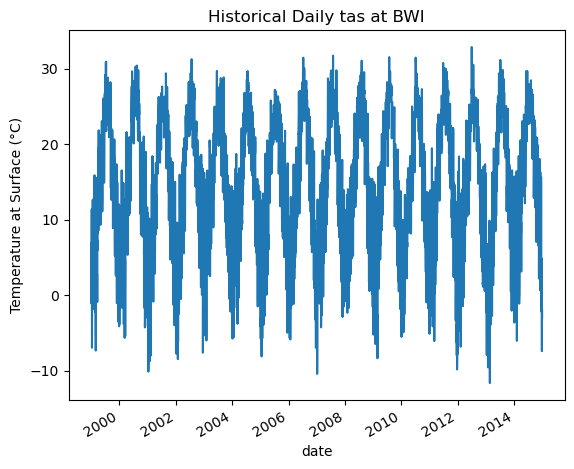

In [2]:
import matplotlib.pyplot as plt
ts = ds.tas_C.sel()
ts = ts.sel()


ts.plot.line(x='time')
plt.ylabel("Temperature at Surface (°C)")
plt.xlabel("date")
plt.title("Historical Daily tas at BWI")
plt.show()

In [3]:
import pandas as pd
# Load the dataset
fn2 = "C:/Users/jenna/OneDrive/Desktop/Fall 2025/Energy Meterology/Final Proj/data/BWI_Hist_Data.csv"
df = pd.read_csv(fn2)

# Inspect the data
print(df.head())
print(df.info())

       STATION                                               NAME       DATE  \
0  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US  1/14/1999   
1  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US  1/15/1999   
2  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US  1/16/1999   
3  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US  1/17/1999   
4  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US  1/18/1999   

   TAVG  TMAX  TMIN  
0  30.0    34    26  
1  30.0    35    25  
2  37.0    52    21  
3  42.0    56    28  
4  45.0    58    31  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6576 entries, 0 to 6575
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  6576 non-null   object 
 1   NAME     6576 non-null   object 
 2   DATE     6576 non-null   object 
 3   TAVG     6568 non-null   float64
 4   TMAX     6576 non-null   int64  
 5   TMIN     6

In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])
df_cleaned = df.dropna(subset=['TAVG']).copy()

# Filter and convert to Celsius (C = (F - 32) * 5/9)
start_date = '1999-01-01'
end_date = '2014-12-31'
df_filtered = df_cleaned[(df_cleaned['DATE'] >= start_date) & (df_cleaned['DATE'] <= end_date)].copy()
df_filtered['TAVG_C'] = (df_filtered['TAVG'] - 32) * 5/9
df_filtered['DATE'] = pd.to_datetime(df_filtered['DATE'])

print(df_filtered)

          STATION                                               NAME  \
0     USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
1     USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
2     USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
3     USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
4     USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
...           ...                                                ...   
5826  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
5827  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
5828  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
5829  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   
5830  USW00093721  BALTIMORE WASHINGTON INTERNATIONAL AIRPORT, MD US   

           DATE  TAVG  TMAX  TMIN    TAVG_C  
0    1999-01-14  30.0    34    26 -1.111111  
1    1999-01-15  30.0    35    25 -1.111111

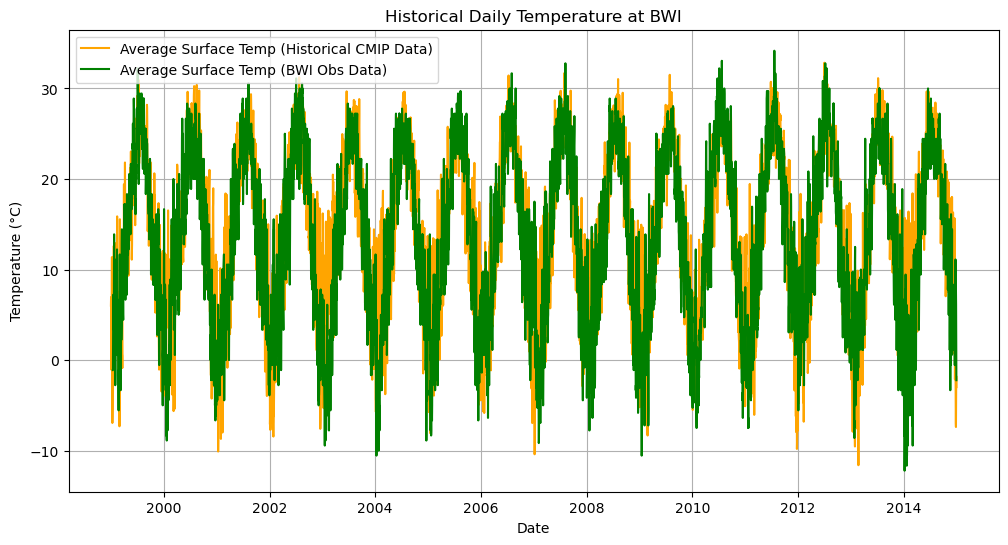

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import cftime

# Convert df_filtered DATE to datetime
df_filtered['DATE'] = pd.to_datetime(df_filtered['DATE'])

# Convert cftime.DatetimeNoLeap to matplotlib numeric dates
ts_time_nums = mdates.date2num([pd.Timestamp(str(t)) for t in ts['time'].values])

fig, ax = plt.subplots(figsize=(12,6))

# Plot ts
ax.plot(ts_time_nums, ts.values, color='orange', label='Average Surface Temp (Historical CMIP Data)')

# Plot df_filtered
ax.plot(df_filtered['DATE'], df_filtered['TAVG_C'], color='g', label='Average Surface Temp (BWI Obs Data)')

# Format x-axis as dates
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.YearLocator(2))  # tick every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Historical Daily Temperature at BWI")
ax.legend()
ax.grid(True)

plt.show()

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# ts dates as just date
ts_df = pd.DataFrame({
    'DATE': [pd.Timestamp(str(t)).date() for t in ts['time'].values],
    'tas_C': ts.values
})

# df_filtered dates as just date
df_filtered['DATE_ONLY'] = df_filtered['DATE'].dt.date

# Merge on just the date
merged = pd.merge(ts_df, df_filtered[['DATE_ONLY', 'TAVG_C']], 
                  left_on='DATE', right_on='DATE_ONLY', how='inner')

# Now calculate correlation
from scipy.stats import pearsonr

r, p_value = pearsonr(merged['tas_C'], merged['TAVG_C'])
print(f"Pearson r: {r:.4f}")
print(f"P-value: {p_value:.4e}")

Pearson r: 0.7843
P-value: 0.0000e+00
